# Нейросеть для предсказания калорийности блюд

**Задача:** создать и обучить нейросеть, которая будет предсказывать калорийность блюд.  
Полученную модель можно интегрировать во многие fitness- и health-приложения — она будет полезна тем, кто следит за своим здоровьем.

### 🎯 Целевая метрика

Модель считается готовой к интеграции в продукт, если достигает точности:

**MAE < 50**  
*(MAE — Mean Absolute Error)*

на тестовой выборке.

### 📘 Датасет

Данные можно скачать здесь:  
**https://disk.yandex.ru/d/kz9g5msVqtahiw**

In [1]:
# Автоматическая перезагрузка модулей при изменении (для разработки)
%load_ext autoreload
%autoreload 2

In [17]:
import random
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import DataLoader

from transformers import AutoTokenizer
import torchmetrics
from tqdm import tqdm

from scripts.train import train
from scripts.model import MultimodalModel
from scripts.dataset import (
    get_train_loader,
    get_val_loader,
)
from scripts.validate import (
    validate,
    get_predictions_with_errors,
)

In [18]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

### Загрузка данных

In [5]:
# Загрузка данных
data_path = Path('data')
dish_df = pd.read_csv(data_path / 'dish.csv')
ingredients_df = pd.read_csv(data_path / 'ingredients.csv')

print(f"Загружено блюд: {len(dish_df)}")
print(f"Загружено ингредиентов: {len(ingredients_df)}")

Загружено блюд: 3262
Загружено ингредиентов: 555


In [6]:
# Создаем словарь для быстрого поиска названий ингредиентов по ID
ingredients_dict = dict(zip(ingredients_df['id'], ingredients_df['ingr']))

# Функция для преобразования строки ингредиентов в список названий через запятую
def convert_ingredients_to_names(ingr_str):
    """
    Преобразует строку вида 'ingr_0000000508;ingr_0000000122;...' 
    в строку названий через запятую 'ingredient1, ingredient2, ...'
    """
    if pd.isna(ingr_str) or ingr_str == '':
        return ''
    
    # Разделяем по точке с запятой
    ingr_ids = str(ingr_str).split(';')
    ingr_names = []
    
    for ingr_id in ingr_ids:
        ingr_id = ingr_id.strip()
        if ingr_id.startswith('ingr_'):
            # Извлекаем числовой ID
            try:
                num_id = int(ingr_id.replace('ingr_', ''))
                # Получаем название ингредиента из словаря
                if num_id in ingredients_dict:
                    ingr_names.append(ingredients_dict[num_id])
            except ValueError:
                continue
    
    # Объединяем через запятую
    return ', '.join(ingr_names)

# Применяем функцию к колонке ingredients
dish_df['ingredients_names'] = dish_df['ingredients'].apply(convert_ingredients_to_names)

## EDA

In [6]:
dish_df.head()

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  \
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test   
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train   
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test   
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train   
4                                    ingr_0000000453  train   

                                   ingredients_names  
0  soy sauce, garlic, white rice, parsley, onions...  
1  pepper, white rice, mixed greens, garlic, soy ...  
2  jalapenos, lemon juice, pork, wheat berry, cab...  
3           cherry tomatoes, cucumbers, baby carrots  
4                                         deprecated

In [7]:
dish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dish_id            3262 non-null   object 
 1   total_calories     3262 non-null   float64
 2   total_mass         3262 non-null   float64
 3   ingredients        3262 non-null   object 
 4   split              3262 non-null   object 
 5   ingredients_names  3262 non-null   object 
dtypes: float64(2), object(4)
memory usage: 153.0+ KB


In [8]:
# Проверка пропусков в ingredients_names
null_count = dish_df['ingredients_names'].isnull().sum()
empty_count = (dish_df['ingredients_names'] == '').sum()

print(f"Количество пропусков (NaN): {null_count}")
print(f"Количество пустых строк: {empty_count}")
print(f"Всего пропусков: {null_count + empty_count}")


Количество пропусков (NaN): 0
Количество пустых строк: 0
Всего пропусков: 0


In [9]:
# Проверка пропусков в total_calories
null_count = dish_df['total_calories'].isnull().sum()

print(f"Количество пропусков (NaN): {null_count}")
print(f"Всего пропусков: {null_count}")

Количество пропусков (NaN): 0
Всего пропусков: 0


In [10]:
# Проверка количества записей с калорийностью 0
zero_calories_count = (dish_df['total_calories'] == 0).sum()
total_records = len(dish_df)

print(f"Количество записей с калорийностью 0: {zero_calories_count}")

Количество записей с калорийностью 0: 2


Пропусков по целевым переменным не наблюдается

In [11]:
# Фильтрация и удаление записей с калорийностью 0
records_before = len(dish_df)
# Удаляем записи с калорийностью 0
dish_df = dish_df[dish_df['total_calories'] != 0].copy()

In [12]:
# Проверка повторений в ingredients_df
duplicated_ingr = ingredients_df[ingredients_df['ingr'].duplicated(keep=False)]
duplicated_ingr.sort_values('ingr')


id        ingr
230  231  deprecated
452  453  deprecated
457  458  deprecated
469  470  deprecated

In [13]:
# Вывод всех строк из dish_df с дублирующимися ингредиентами
# Получаем ID дублирующихся ингредиентов
duplicated_ids = duplicated_ingr['id'].tolist()

# Создаем маску для поиска строк, содержащих эти ID
mask = dish_df['ingredients'].apply(
    lambda x: any(f'ingr_{id:010d}' in str(x) for id in duplicated_ids)
)

# Выводим количество строк с дублирующимися ингредиентами
dish_df[mask].size


186

In [14]:
# Добавление ID к названию ингредиента для дубликатов
# Находим дубликаты
duplicated_mask = ingredients_df['ingr'].duplicated(keep=False)

# Добавляем ID к названию для дубликатов
ingredients_df.loc[duplicated_mask, 'ingr'] = (
    'ingredient_' + 
    ingredients_df.loc[duplicated_mask, 'id'].astype(str)
)

# Обновляем словарь
ingredients_dict = dict(zip(ingredients_df['id'], ingredients_df['ingr']))

# Пересоздаем ingredients_names с обновленным словарем
dish_df['ingredients_names'] = dish_df['ingredients'].apply(convert_ingredients_to_names)


In [15]:
dish_df.head()

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  \
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test   
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train   
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test   
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train   
4                                    ingr_0000000453  train   

                                   ingredients_names  
0  soy sauce, garlic, white rice, parsley, onions...  
1  pepper, white rice, mixed greens, garlic, soy ...  
2  jalapenos, lemon juice, pork, wheat berry, cab...  
3           cherry tomatoes, cucumbers, baby carrots  
4                                     ingredient_453

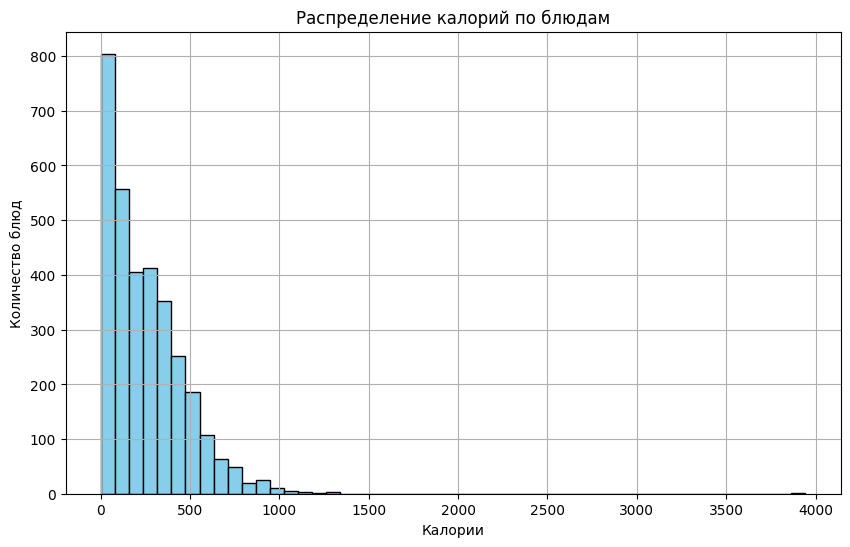

In [16]:
# Визуализация распределения калорий
plt.figure(figsize=(10, 6))
plt.hist(dish_df['total_calories'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Калории')
plt.ylabel('Количество блюд')
plt.title('Распределение калорий по блюдам')
plt.grid(True)
plt.show()

Распределение калорий по блюдам сильно смещено вправо, поэтому для дальнейшего анализа данные стоит нормализовать и логарифмировать, чтобы уменьшить влияние выбросов и приблизить распределение к более симметричному.

Корреляция между массой и калориями: 0.7595


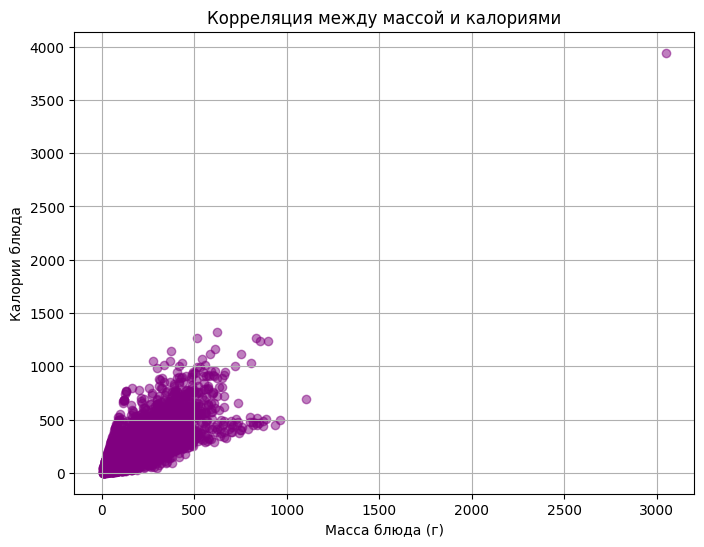

In [17]:
# Проверяем корреляцию между массой и калориями
correlation = dish_df['total_mass'].corr(dish_df['total_calories'])
print(f"Корреляция между массой и калориями: {correlation:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(dish_df['total_mass'], dish_df['total_calories'], alpha=0.5, color='purple')
plt.xlabel('Масса блюда (г)')
plt.ylabel('Калории блюда')
plt.title('Корреляция между массой и калориями')
plt.grid(True)
plt.show()

На графике видно заметную положительную корреляцию: с увеличением массы блюда растёт и его калорийность, хотя присутствуют выбросы, которые могут искажать анализ. 


1. Dish ID: dish_1562011727
   Калории: 372.4 ккал | Масса: 182.0 г
   Ингредиенты: wheat berry, pork, jalapenos, lemon juice, pepper, cabbage, carrot, garlic, salt, parsley, mayonnaise, olive oil


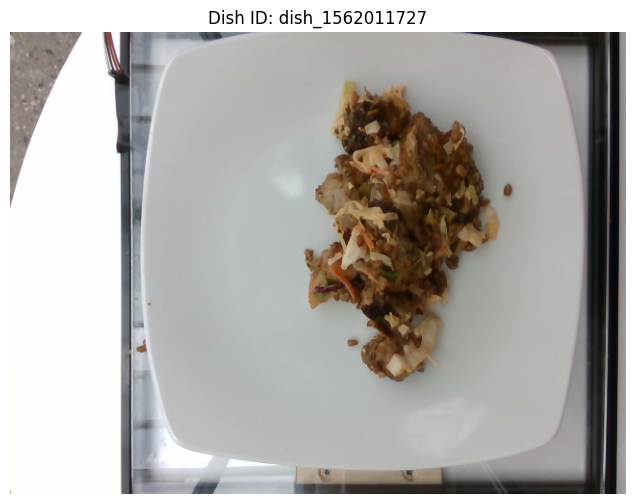


2. Dish ID: dish_1561134128
   Калории: 58.5 ккал | Масса: 141.0 г
   Ингредиенты: berries, watermelon


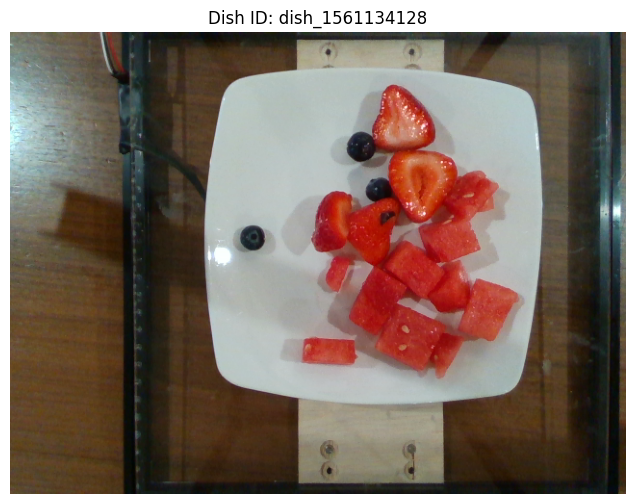


3. Dish ID: dish_1558720364
   Калории: 73.8 ккал | Масса: 142.0 г
   Ингредиенты: apple


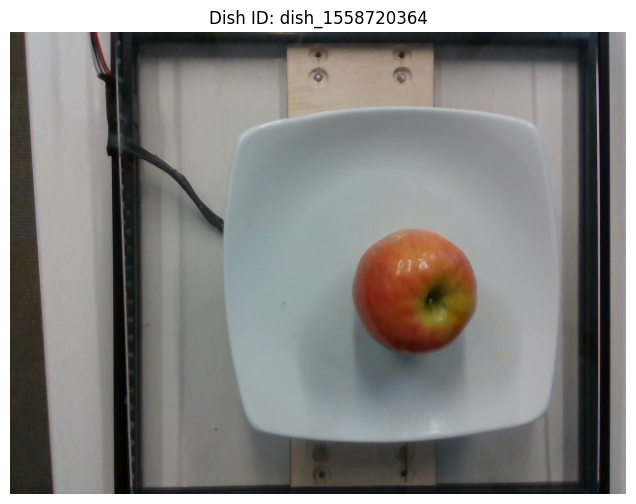


4. Dish ID: dish_1558722473
   Калории: 149.6 ккал | Масса: 379.0 г
   Ингредиенты: cherry tomatoes, cauliflower, apple, carrot


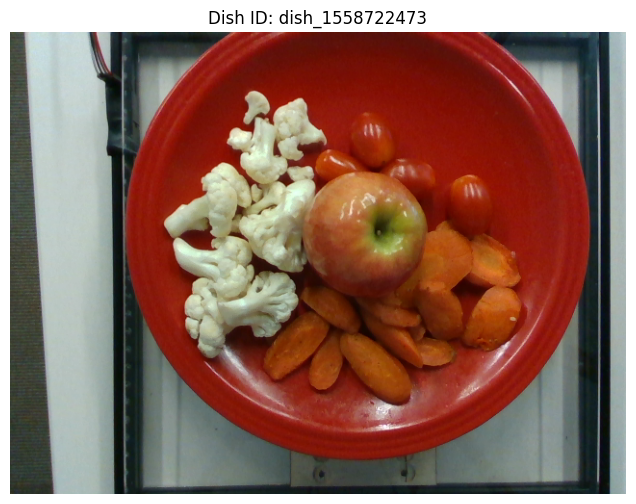


5. Dish ID: dish_1561405864
   Калории: 197.1 ккал | Масса: 106.0 г
   Ингредиенты: olive oil, broccoli, green onions, garlic, cheese pizza, soy sauce, salt, vinegar, white rice, spinach (raw), green beans, chicken, ginger


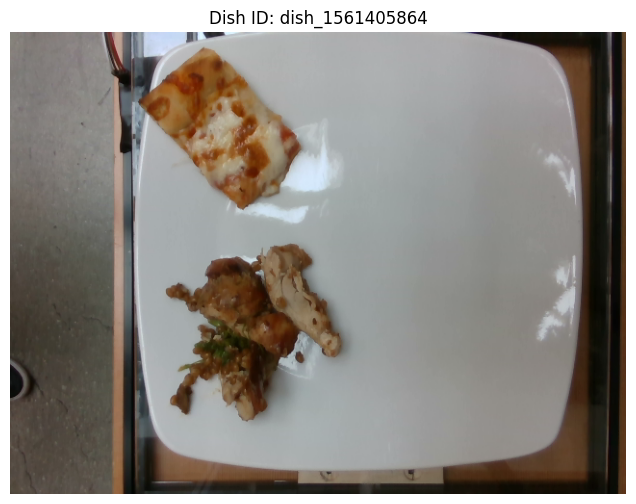

In [18]:
# Выбираем 5 случайных блюд и выводим последовательно
random_indices = random.sample(range(len(dish_df)), min(5, len(dish_df)))
random_dishes = dish_df.iloc[random_indices]

for idx, (_, row) in enumerate(random_dishes.iterrows(), 1):
    dish_id = row['dish_id']
    img_path = data_path / 'images' / dish_id / 'rgb.png'
    
    print(f"\n{'='*80}")
    print(f"{idx}. Dish ID: {dish_id}")
    print(f"   Калории: {row['total_calories']:.1f} ккал | Масса: {row['total_mass']:.1f} г")
    print(f"   Ингредиенты: {row['ingredients_names']}")
    print(f"{'='*80}")
    
    # Показываем изображение
    if img_path.exists():
        img = Image.open(img_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Dish ID: {dish_id}", fontsize=12)
        plt.show()
    else:
        print(f"   ⚠️ Изображение не найдено: {img_path}")


Найдено блюд с дублирующимися ингредиентами: 31
Выводим 5 случайных:


1. Dish ID: dish_1558028142
   Калории: 21.9 ккал | Масса: 73.0 г
   Ингредиенты: ingredient_458


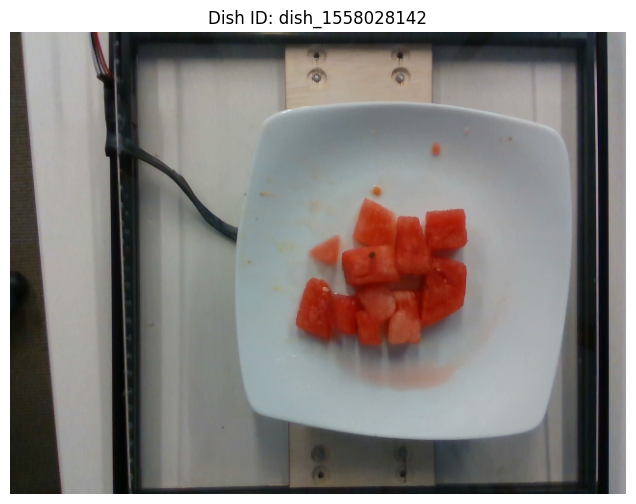


2. Dish ID: dish_1558115364
   Калории: 485.3 ккал | Масса: 313.0 г
   Ингредиенты: potatoes, ingredient_453, almonds, bacon


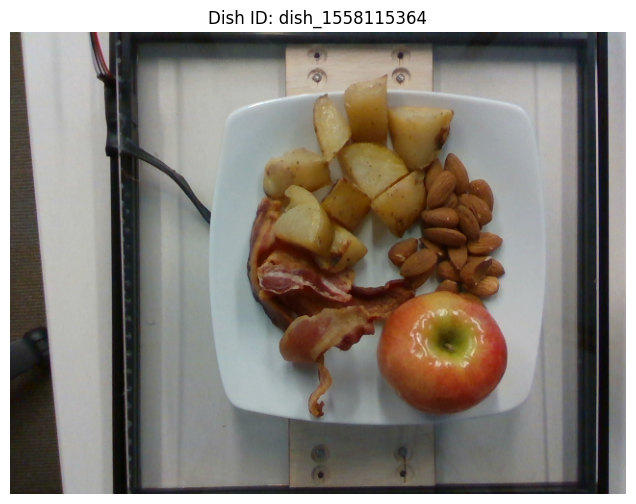


3. Dish ID: dish_1558031394
   Калории: 237.4 ккал | Масса: 318.0 г
   Ингредиенты: cantaloupe, ingredient_458, potatoes, yam


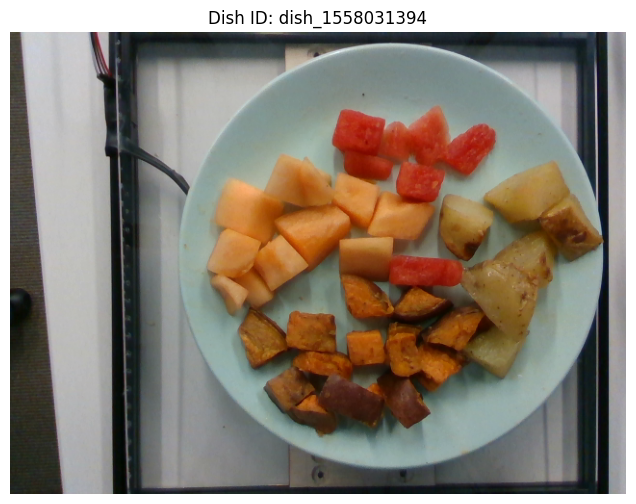


4. Dish ID: dish_1558373159
   Калории: 1013.3 ккал | Масса: 334.0 г
   Ингредиенты: sausage, ingredient_453, almonds


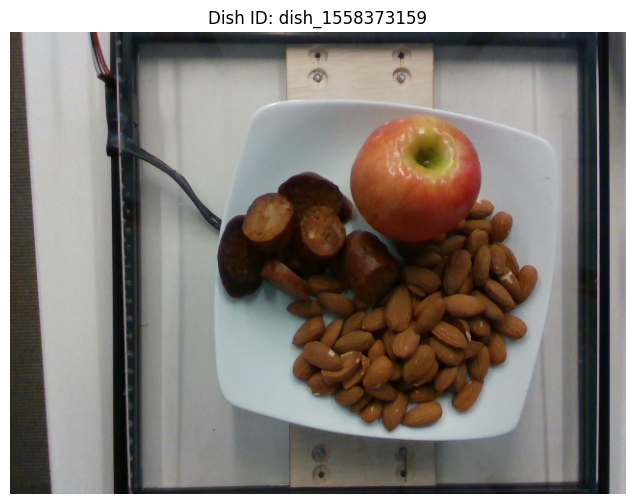


5. Dish ID: dish_1558380152
   Калории: 74.4 ккал | Масса: 143.0 г
   Ингредиенты: ingredient_453


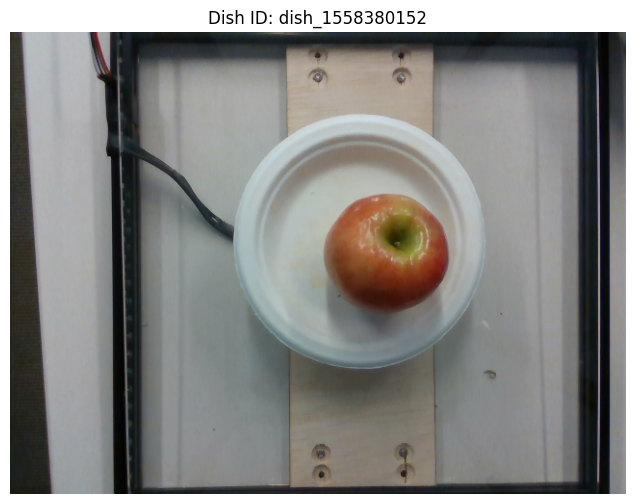

In [19]:
# Выбираем 5 случайных блюд с дублирующимися ингредиентами
# Получаем ID дублирующихся ингредиентов
duplicated_ids = duplicated_ingr['id'].tolist()

# Создаем маску для поиска строк, содержащих эти ID
mask = dish_df['ingredients'].apply(
    lambda x: any(f'ingr_{id:010d}' in str(x) for id in duplicated_ids)
)

# Фильтруем блюда с дублирующимися ингредиентами
dishes_with_duplicated = dish_df[mask]

# Выбираем 5 случайных
if len(dishes_with_duplicated) > 0:
    n_samples = min(5, len(dishes_with_duplicated))
    random_indices = random.sample(range(len(dishes_with_duplicated)), n_samples)
    random_dishes = dishes_with_duplicated.iloc[random_indices]
    
    print(f"Найдено блюд с дублирующимися ингредиентами: {len(dishes_with_duplicated)}")
    print(f"Выводим {n_samples} случайных:\n")
    
    for idx, (_, row) in enumerate(random_dishes.iterrows(), 1):
        dish_id = row['dish_id']
        img_path = data_path / 'images' / dish_id / 'rgb.png'
        
        print(f"\n{'='*80}")
        print(f"{idx}. Dish ID: {dish_id}")
        print(f"   Калории: {row['total_calories']:.1f} ккал | Масса: {row['total_mass']:.1f} г")
        print(f"   Ингредиенты: {row['ingredients_names']}")
        print(f"{'='*80}")
        
        # Показываем изображение
        if img_path.exists():
            img = Image.open(img_path)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Dish ID: {dish_id}", fontsize=12)
            plt.show()
        else:
            print(f"   ⚠️ Изображение не найдено: {img_path}")
else:
    print("Блюд с дублирующимися ингредиентами не найдено")


## Видение решения задачи

### Подход
- Мультимодальная модель: текст (transformer) + изображение (CNN).
- Transfer Learning и последующее объединение эмбеддингов с разморозакой последних слоев.

### Учёт анализа данных
- Калории распределены с сильным смещением и выбросами → требуется логарифмирование целевой переменной и нормализация признаков (включая массу).
- Масса и калории коррелируют неравномерно, присутствуют экстремумы → возможен robust scaling или обработка выбросов.

### Аугментации
- Изображения: геометрические, цветовые, нормализация.
- Текст: мягкие аугментации (синонимы, перестановки).
- Валидация: только ресайз и center crop.

### Метрики и обучение
- Основная метрика: MAE; функция потерь — MSE.
- Постепенный fine-tuning с разными learning rates и контролем переобучения (train/val MAE).


## Обучение модели

In [7]:
# Разделение на тренировочный и тестовый датасет по полю split
train_df = dish_df[dish_df['split'] == 'train'].copy()
test_df = dish_df[dish_df['split'] == 'test'].copy()

print(f"Тренировочный датасет: {len(train_df)} записей ({len(train_df)/len(dish_df)*100:.1f}%)")
print(f"Тестовый датасет: {len(test_df)} записей ({len(test_df)/len(dish_df)*100:.1f}%)")

Тренировочный датасет: 2755 записей (84.5%)
Тестовый датасет: 507 записей (15.5%)


In [21]:
# Сохранение train и test датасетов в папку data
train_df.to_csv(data_path / 'train.csv', index=False)
test_df.to_csv(data_path / 'test.csv', index=False)

In [9]:
class Config:
    SEED = RANDOM_SEED

    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    BATCH_SIZE = 256
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    CLASSIFIER_LR = 1e-3
    EPOCHS = 30
    DROPOUT = 0.3
    HIDDEN_DIM = 256

    TRAIN_DF_PATH = "data/train.csv"
    VAL_DF_PATH = "data/test.csv"
    SAVE_PATH = "best_model.pth"

In [10]:
cfg = Config()

In [24]:
train(cfg, DEVICE) 

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

d:\miniconda3\envs\dle\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


training started


Epoch 1/30 [Val]: 100%|██████████| 2/2 [00:11<00:00,  5.79s/it, MAE=105.4146]


Epoch 0/29 | avg_Loss: 0.8258 | Train MAE: 146.0314| Val MAE: 105.4146 | LR: 3.00e-05
New best model, epoch: 0, Val MAE: 105.4146


Epoch 2/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.40s/it, MAE=89.1559]


Epoch 1/29 | avg_Loss: 0.5341 | Train MAE: 107.7063| Val MAE: 89.1559 | LR: 3.00e-05
New best model, epoch: 1, Val MAE: 89.1559


Epoch 3/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.37s/it, MAE=80.1854]


Epoch 2/29 | avg_Loss: 0.4274 | Train MAE: 96.1891| Val MAE: 80.1854 | LR: 3.00e-05
New best model, epoch: 2, Val MAE: 80.1854


Epoch 4/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it, MAE=73.9128]


Epoch 3/29 | avg_Loss: 0.3944 | Train MAE: 89.9455| Val MAE: 73.9128 | LR: 3.00e-05
New best model, epoch: 3, Val MAE: 73.9128


Epoch 5/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.30s/it, MAE=70.3532]


Epoch 4/29 | avg_Loss: 0.3631 | Train MAE: 86.3284| Val MAE: 70.3532 | LR: 3.00e-05
New best model, epoch: 4, Val MAE: 70.3532


Epoch 6/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.30s/it, MAE=65.7421]


Epoch 5/29 | avg_Loss: 0.3398 | Train MAE: 80.9769| Val MAE: 65.7421 | LR: 3.00e-05
New best model, epoch: 5, Val MAE: 65.7421


Epoch 7/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.28s/it, MAE=65.4553]


Epoch 6/29 | avg_Loss: 0.3047 | Train MAE: 77.4885| Val MAE: 65.4553 | LR: 3.00e-05
New best model, epoch: 6, Val MAE: 65.4553


Epoch 8/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it, MAE=60.2257]


Epoch 7/29 | avg_Loss: 0.2938 | Train MAE: 74.8549| Val MAE: 60.2257 | LR: 3.00e-05
New best model, epoch: 7, Val MAE: 60.2257


Epoch 9/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.38s/it, MAE=56.6811]


Epoch 8/29 | avg_Loss: 0.2708 | Train MAE: 71.3291| Val MAE: 56.6811 | LR: 3.00e-05
New best model, epoch: 8, Val MAE: 56.6811


Epoch 10/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.30s/it, MAE=55.9652]


Epoch 9/29 | avg_Loss: 0.2635 | Train MAE: 70.3919| Val MAE: 55.9652 | LR: 3.00e-05
New best model, epoch: 9, Val MAE: 55.9652


Epoch 11/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it, MAE=57.2941]


Epoch 10/29 | avg_Loss: 0.2452 | Train MAE: 68.0370| Val MAE: 57.2941 | LR: 3.00e-05
No improvement for 1 epochs. Best Val MAE: 55.9652


Epoch 12/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it, MAE=59.2373]


Epoch 11/29 | avg_Loss: 0.2365 | Train MAE: 65.9255| Val MAE: 59.2373 | LR: 3.00e-05
No improvement for 2 epochs. Best Val MAE: 55.9652


Epoch 13/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it, MAE=54.9124]


Epoch 12/29 | avg_Loss: 0.2375 | Train MAE: 65.8363| Val MAE: 54.9124 | LR: 3.00e-05
New best model, epoch: 12, Val MAE: 54.9124


Epoch 14/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it, MAE=52.9666]


Epoch 13/29 | avg_Loss: 0.2052 | Train MAE: 62.9545| Val MAE: 52.9666 | LR: 3.00e-05
New best model, epoch: 13, Val MAE: 52.9666


Epoch 15/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it, MAE=52.4768]


Epoch 14/29 | avg_Loss: 0.2022 | Train MAE: 61.2923| Val MAE: 52.4768 | LR: 3.00e-05
New best model, epoch: 14, Val MAE: 52.4768


Epoch 16/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it, MAE=51.6324]


Epoch 15/29 | avg_Loss: 0.1951 | Train MAE: 58.6132| Val MAE: 51.6324 | LR: 3.00e-05
New best model, epoch: 15, Val MAE: 51.6324


Epoch 17/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.29s/it, MAE=51.7060]


Epoch 16/29 | avg_Loss: 0.2040 | Train MAE: 59.0300| Val MAE: 51.7060 | LR: 3.00e-05
No improvement for 1 epochs. Best Val MAE: 51.6324


Epoch 18/30 [Val]: 100%|██████████| 2/2 [00:11<00:00,  5.76s/it, MAE=51.2679]


Epoch 17/29 | avg_Loss: 0.1928 | Train MAE: 57.8323| Val MAE: 51.2679 | LR: 3.00e-05
New best model, epoch: 17, Val MAE: 51.2679


Epoch 19/30 [Val]: 100%|██████████| 2/2 [00:11<00:00,  5.67s/it, MAE=51.4598]


Epoch 18/29 | avg_Loss: 0.1786 | Train MAE: 56.9161| Val MAE: 51.4598 | LR: 3.00e-05
No improvement for 1 epochs. Best Val MAE: 51.2679


Epoch 20/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.20s/it, MAE=51.3281]


Epoch 19/29 | avg_Loss: 0.1747 | Train MAE: 57.2917| Val MAE: 51.3281 | LR: 3.00e-05
No improvement for 2 epochs. Best Val MAE: 51.2679


Epoch 21/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.20s/it, MAE=52.8117]


Epoch 20/29 | avg_Loss: 0.1743 | Train MAE: 55.2063| Val MAE: 52.8117 | LR: 3.00e-05
No improvement for 3 epochs. Best Val MAE: 51.2679


Epoch 22/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.25s/it, MAE=52.6507]


Epoch 21/29 | avg_Loss: 0.1815 | Train MAE: 54.1423| Val MAE: 52.6507 | LR: 1.50e-05
No improvement for 4 epochs. Best Val MAE: 51.2679


Epoch 23/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.17s/it, MAE=49.7525]


Epoch 22/29 | avg_Loss: 0.1587 | Train MAE: 53.2664| Val MAE: 49.7525 | LR: 1.50e-05
New best model, epoch: 22, Val MAE: 49.7525


Epoch 24/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.17s/it, MAE=48.1664]


Epoch 23/29 | avg_Loss: 0.1532 | Train MAE: 53.1960| Val MAE: 48.1664 | LR: 1.50e-05
New best model, epoch: 23, Val MAE: 48.1664


Epoch 25/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.16s/it, MAE=48.7434]


Epoch 24/29 | avg_Loss: 0.1544 | Train MAE: 53.5123| Val MAE: 48.7434 | LR: 1.50e-05
No improvement for 1 epochs. Best Val MAE: 48.1664


Epoch 26/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.20s/it, MAE=49.0378]


Epoch 25/29 | avg_Loss: 0.1550 | Train MAE: 53.9004| Val MAE: 49.0378 | LR: 1.50e-05
No improvement for 2 epochs. Best Val MAE: 48.1664


Epoch 27/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.26s/it, MAE=49.2316]


Epoch 26/29 | avg_Loss: 0.1566 | Train MAE: 52.8612| Val MAE: 49.2316 | LR: 1.50e-05
No improvement for 3 epochs. Best Val MAE: 48.1664


Epoch 28/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.19s/it, MAE=48.7818]


Epoch 27/29 | avg_Loss: 0.1481 | Train MAE: 52.1030| Val MAE: 48.7818 | LR: 7.50e-06
No improvement for 4 epochs. Best Val MAE: 48.1664


Epoch 29/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.17s/it, MAE=47.8735]


Epoch 28/29 | avg_Loss: 0.1590 | Train MAE: 51.5352| Val MAE: 47.8735 | LR: 7.50e-06
New best model, epoch: 28, Val MAE: 47.8735


Epoch 30/30 [Val]: 100%|██████████| 2/2 [00:10<00:00,  5.30s/it, MAE=49.3772]

Epoch 29/29 | avg_Loss: 0.1520 | Train MAE: 50.7556| Val MAE: 49.3772 | LR: 7.50e-06
No improvement for 1 epochs. Best Val MAE: 47.8735


**Выводы по обучению модели:**

- Лучшая точность достигнута на эпохе **29**: Val MAE = **47.87**.
- На последней эпохе качество ухудшилось: Val MAE = **49.38**.
- Train loss и Train MAE продолжают снижаться → модель дообучается.
- Разрыв между Train и Val небольшой → переобучение минимальное.
- Обучение можно завершать: улучшения валидционного качества остановились.

## Валидация

In [16]:
# Создаем экземпляр модели с той же конфигурацией
model = MultimodalModel(cfg).to(DEVICE)
# Загружаем веса из сохраненного файла
model_path = Path(cfg.SAVE_PATH)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))

C:\Users\le0\AppData\Local\Temp\ipykernel_7596\3851195538.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=DEVIC

<All keys matched successfully>

Вычисление предсказаний: 100%|██████████| 2/2 [00:11<00:00,  6.00s/it]



ТОП-5 БЛЮД С НАИМЕНЕЕ ТОЧНЫМИ ПРЕДСКАЗАНИЯМИ

1. Dish ID: dish_1566328831
   Фактическая калорийность: 941.6 ккал
   Предсказанная калорийность: 455.1 ккал
   Абсолютная ошибка: 486.5 ккал
   Масса: 500.0 г
   Ингредиенты: pizza, cherry tomatoes, chicken, pineapple, olives


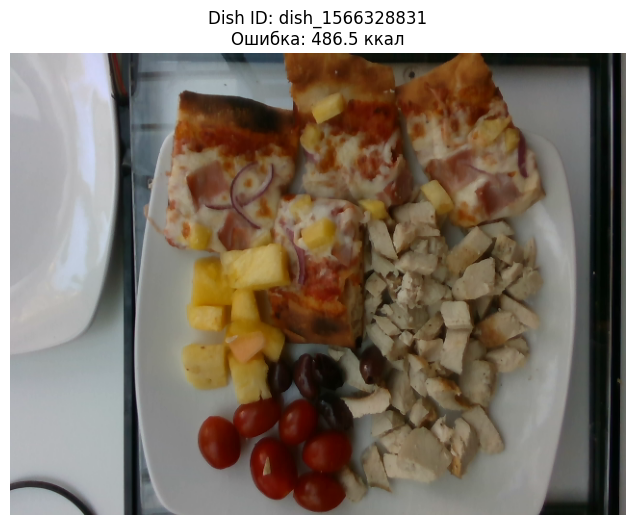


2. Dish ID: dish_1566328805
   Фактическая калорийность: 927.8 ккал
   Предсказанная калорийность: 520.4 ккал
   Абсолютная ошибка: 407.4 ккал
   Масса: 488.0 г
   Ингредиенты: cherry tomatoes, pizza, chicken, pineapple


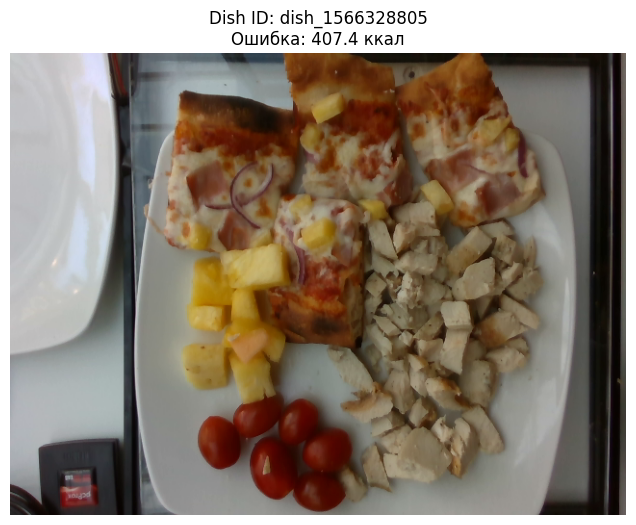


3. Dish ID: dish_1566501594
   Фактическая калорийность: 508.0 ккал
   Предсказанная калорийность: 111.0 ккал
   Абсолютная ошибка: 397.1 ккал
   Масса: 109.0 г
   Ингредиенты: brownies


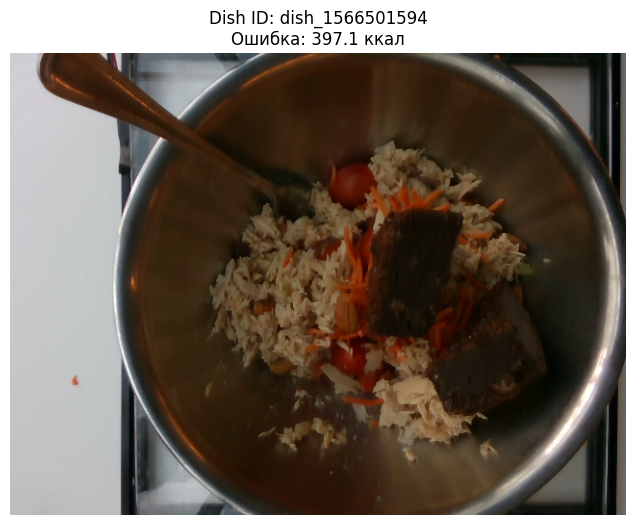


4. Dish ID: dish_1565123881
   Фактическая калорийность: 406.8 ккал
   Предсказанная калорийность: 722.1 ккал
   Абсолютная ошибка: 315.2 ккал
   Масса: 515.0 г
   Ингредиенты: caesar salad, olive oil, onions, cheese pizza, zucchini, spinach (cooked), millet, shallots, bok choy, salt, beef, chayote squash, vinegar


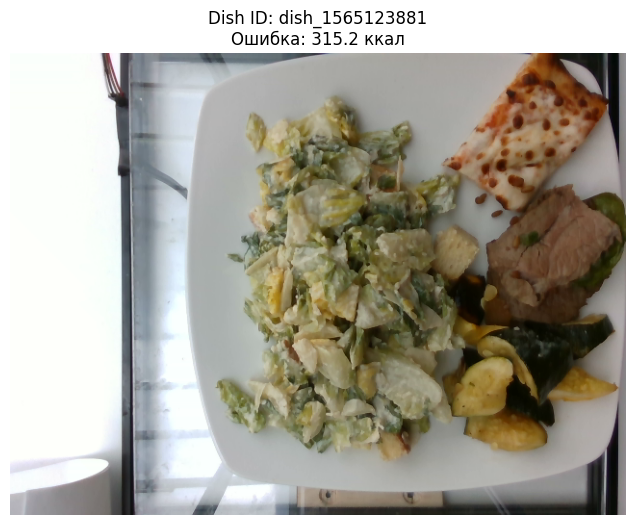


5. Dish ID: dish_1564687090
   Фактическая калорийность: 498.0 ккал
   Предсказанная калорийность: 779.7 ккал
   Абсолютная ошибка: 281.7 ккал
   Масса: 416.0 г
   Ингредиенты: fish, millet, white rice, ketchup, steak, spinach (raw), jalapenos, onions, wheat berry, olive oil, bell peppers, cilantro, vinegar, kale, green beans, lime, shallots, salt


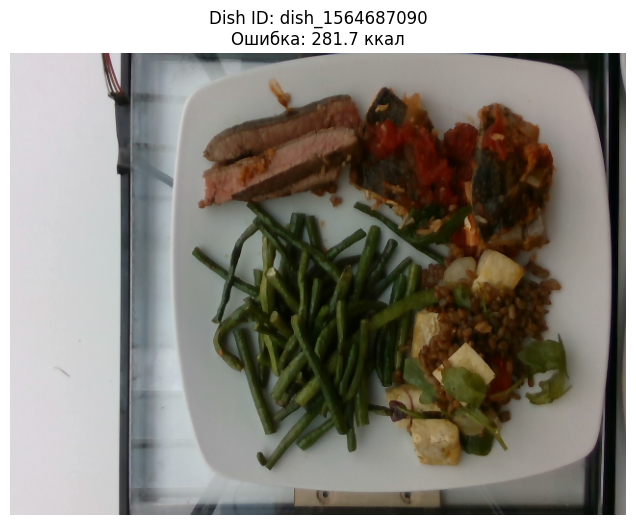

In [19]:
# Создаем валидационный загрузчик используя функцию из dataset.py
val_loader, target_mean, target_std, mass_mean, mass_std = get_val_loader(cfg)

# Получаем предсказания и ошибки используя функцию из validate.py
results = get_predictions_with_errors(
    model, val_loader, DEVICE, 
    target_mean=target_mean, target_std=target_std
)

# Создаем DataFrame с результатами, используя данные из валидационного датасета
test_df = pd.read_csv(cfg.VAL_DF_PATH).reset_index(drop=True)
results_df = test_df.copy()
results_df['predicted'] = results['predictions']
results_df['actual'] = results['targets']
results_df['absolute_error'] = results['absolute_errors']

# Находим топ-5 блюд с наибольшей абсолютной ошибкой
top5_worst = results_df.nlargest(5, 'absolute_error')

print("\n" + "="*80)
print("ТОП-5 БЛЮД С НАИМЕНЕЕ ТОЧНЫМИ ПРЕДСКАЗАНИЯМИ")
print("="*80)

for idx, (_, row) in enumerate(top5_worst.iterrows(), 1):
    print(f"\n{idx}. Dish ID: {row['dish_id']}")
    print(f"   Фактическая калорийность: {row['actual']:.1f} ккал")
    print(f"   Предсказанная калорийность: {row['predicted']:.1f} ккал")
    print(f"   Абсолютная ошибка: {row['absolute_error']:.1f} ккал")
    print(f"   Масса: {row['total_mass']:.1f} г")
    print(f"   Ингредиенты: {row['ingredients_names']}")
    
    # Показываем изображение
    img_path = data_path / 'images' / row['dish_id'] / 'rgb.png'
    if img_path.exists():
        img = Image.open(img_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Dish ID: {row['dish_id']}\nОшибка: {row['absolute_error']:.1f} ккал", fontsize=12)
        plt.show()
    else:
        print(f"   ⚠️ Изображение не найдено: {img_path}")

print("\n" + "="*80)


## Возможные причины низкого качества

### 1. Пицца: занижение калорийности  
**Проблема:** почти в 2 раза ниже реальной.  
**Причины:**  
- Недостаточно примеров высококалорийной пиццы.  
- Игнорируются скрытые жирные добавки (сыр, масло, соусы).  
- Пицца сильно варьируется по толщине, сыру, соусам — в тексте это не видно.

### 2. Десерты: низкая оценка калорийной плотности  
**Проблема:** brownies 508 ккал → модель предсказала 111.  
**Причины:**  
- Сильная опора на массу, игнорирование высокой плотности.  
- Одного слова *brownies* мало для точной оценки.  
- Мало примеров плотных десертов в обучении.

### 3. Многокомпонентные блюда  
**Проблема:** переоценка калорийности салатов/смесей.  
**Причины:**  
- Много ингредиентов → модель завышает вклад каждого.  
- Не учитываются пропорции (много овощей ≠ много калорий).  
- Возможная суммирующая интерпретация (например, “caesar salad + cheese pizza”).

### 4. Архитектурные ограничения  
- Произведение эмбеддингов может «обнулять» важные признаки.  
- Отсутствие учёта пропорций ингредиентов.

### 5. Проблемы данных  
- Недостающие ингредиенты (масла, соусы).  
- Несоответствие изображения и текста.

### 6. Недостаточная выборка  
- Мало примеров: жирные пиццы, плотные десерты, сложные блюда.